In [8]:
from hossam import *

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from scipy.stats import zscore, probplot, shapiro, kstest, jarque_bera
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.graphics.gofplots import qqplot as sm_qqplot
import statsmodels.api as sm


In [9]:
origin = load_data("fish_processed")
yname = "무게"
x = origin.drop(columns=[yname])
y = origin[yname]

x_train, x_test, y_train, y_test= train_test_split(
    x, y, test_size=0.25, random_state=52

)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전


((42, 3), (14, 3), (42,), (14,))

In [10]:
model = LinearRegression(n_jobs=-1)
param_grid = {"fit_intercept": [True, False], "positive":[True, False]}
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1)
gs.fit(x_train, y_train)

estimator = gs.best_estimator_
estimator

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",-1
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",True


## 잔차 구하기

In [11]:
rdf = x_train.copy()
rdf[yname] = y_train

#예측치
rdf["y_pred"] = estimator.predict(x_train)

#잔차
rdf["resid"] = rdf[yname] - rdf["y_pred"]

rdf.head()

,길이,높이,두께,무게,y_pred,resid
19,-0.603177,-0.701884,-0.639841,4.875197,4.829781,0.045416
37,0.548851,0.759978,0.724503,6.244167,6.030390,0.213776
40,0.962686,1.057959,1.202024,6.530878,6.461677,0.069200
6,-1.028197,-0.933258,-0.924079,4.369448,4.386838,-0.017390
24,-0.435406,-0.200574,-0.582993,5.420535,5.004627,0.415908


## 잔차의 선형성

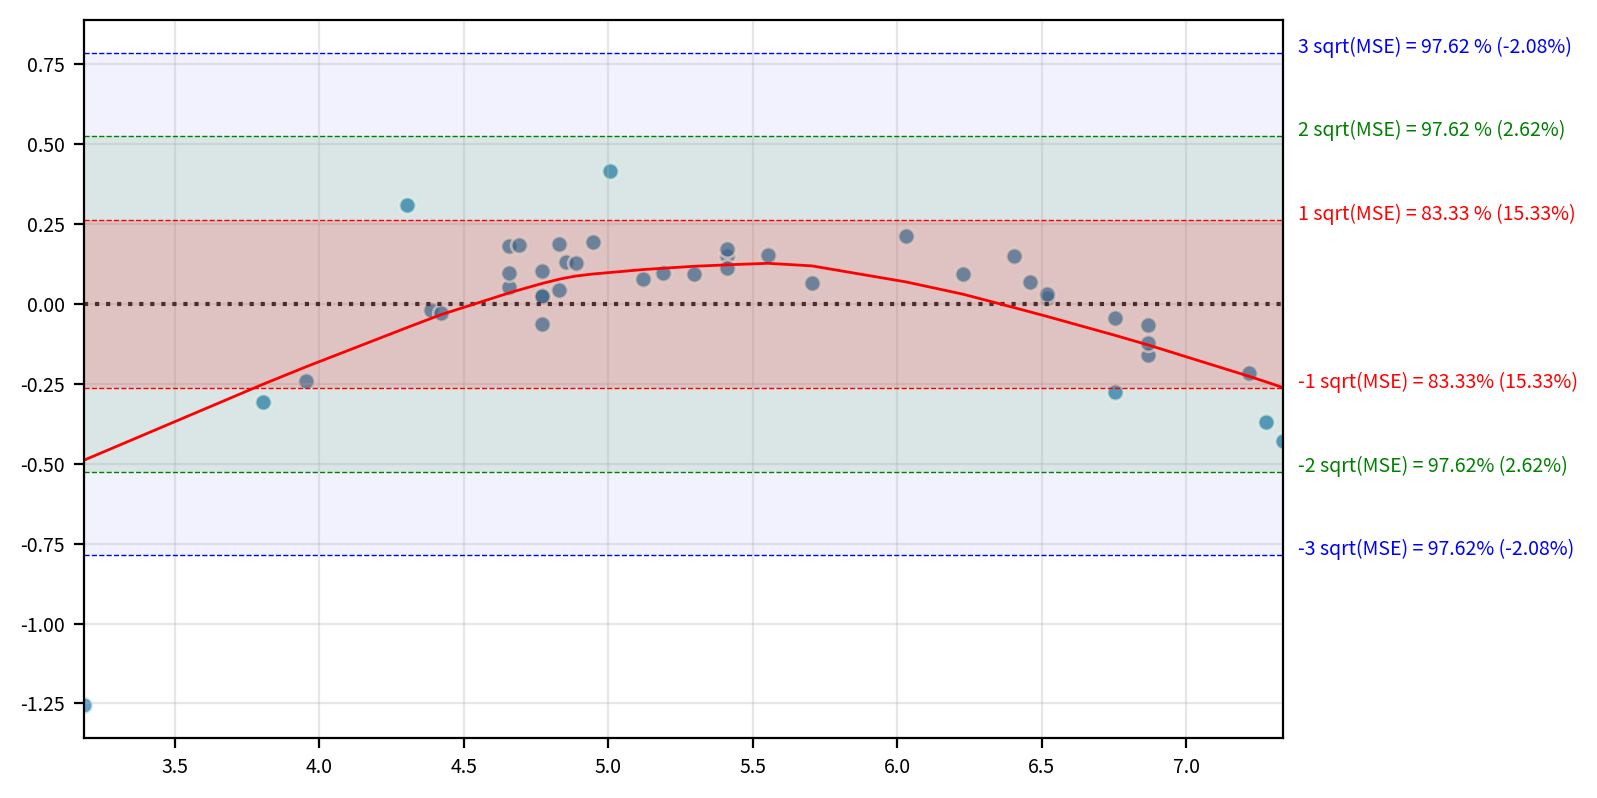

In [12]:
y = rdf[yname].values
y_pred = rdf["y_pred"].values
resid = rdf["resid"].values

figsize=(1600/ my_dpi, 800/my_dpi)
fig, ax = plt.subplots(1,1, figsize=figsize, dpi=my_dpi)

#잔차 산점도
sb.residplot(
    x=y_pred, 
    y=resid,
    lowess=True,
    line_kws={"color": "red", "linewidth":1},
    scatter_kws={"edgecolor": "white", "alpha":0.7},
)
#MSE표시
mse_val = mean_squared_error(y, y_pred)
mse_sq = np.sqrt(mse_val)

r1 = resid[(resid > -mse_sq)&(resid < mse_sq)].size/ resid.size *100
r2 = resid[(resid >-2*mse_sq)&(resid <2* mse_sq)].size/resid.size*100
r3=resid[(resid >-3*mse_sq)&(resid <3* mse_sq)].size/resid.size*100

mse_r = [r1, r2, r3]

xmin, xmax = ax.get_xlim()

#구간별 반투명 색상채우기(안쪽부터 바깥쪽으로, 진한색에서 연한색으로)
colors = ["red", "green", "blue"]
alphas = [0.15, 0.10, 0.05] #안쪽이 더 진하게

ax.axhspan(-3*mse_sq, 3*mse_sq,facecolor=colors[2], alpha=alphas[2], zorder=0 )
ax.axhspan(-2*mse_sq, 2*mse_sq,facecolor=colors[1], alpha=alphas[1], zorder=1 )
ax.axhspan(-mse_sq, mse_sq,facecolor=colors[0], alpha=alphas[0], zorder=2 )

#경계선 그리기
for i, c in enumerate(["red", "green", "blue"]):
    ax.axhline(mse_sq *(i+1), color=c, linestyle="--", linewidth=0.5)
    ax.axhline(mse_sq *(-(i+1)), color=c, linestyle="--", linewidth=0.5)

target = [68, 95, 99.7]
for i, c in enumerate(["red", "green", "blue"]):
    ax.text(
        s=f"{i+1} sqrt(MSE) = {mse_r[i]:.2f} % ({mse_r[i] - target[i]:.2f}%)",
        x=xmax +0.05,
        y=(i+1) *mse_sq,
        color=c,
    )
    ax.text(
        s=f"-{i+1} sqrt(MSE) = {mse_r[i]:.2f}% ({mse_r[i] - target[i]:.2f}%)",
        x=xmax +0.05,
        y=-(i+1) *mse_sq,
        color=c,
    )
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

## 정규성 검정

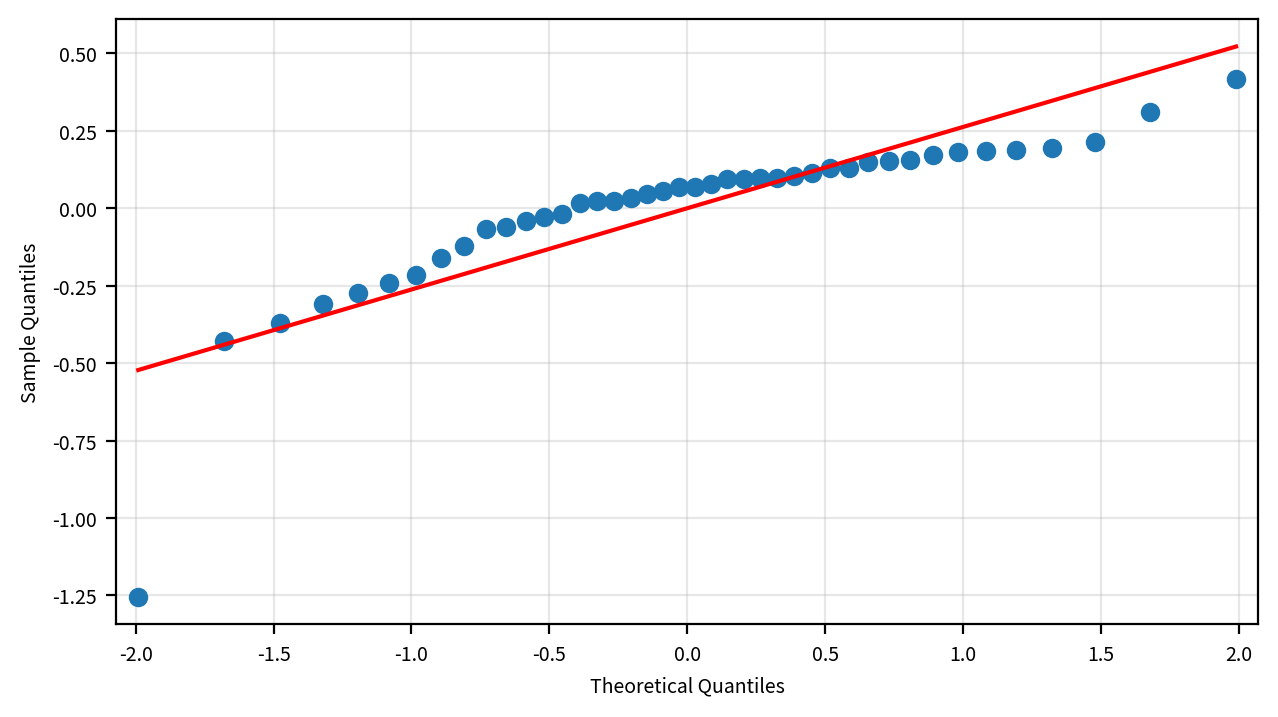

In [13]:
figsize = (1280/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=my_dpi)

sm_qqplot(rdf["resid"], line="s", ax=ax)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

### 통계량을 통한 확인

In [18]:
residuals = rdf["resid"].values
n = len(residuals)
alpha = 0.05
results = []


In [19]:
if n <5000:
    try:
        stat_sw, p_sw = shapiro(residuals)
        significant_sw = p_sw <=alpha

        if significant_sw:
            interpretation_sw = f"정규성 위반 (p={p_sw:.4f}<= {alpha})"
        else:
            interpretation_sw = f"정규성 위반 (p={p_sw:.4f}> {alpha})"
        
        results.append(
            {
                "검정": "Shapiro-Wilk",
                "검정통계량": f"{stat_sw:.4f}",
                "p-value":f"{p_sw:.4f}",
                "유의수준": alpha,
                "정규성_위반": significant_sw,
                "해석": interpretation_sw,
            }
        )
    except Exception as e:
        pass

In [22]:
try:
    stat_jb, p_jb = jarque_bera(residuals)
    significant_jb=p_jb <=alpha

    if significant_jb:
        interpretation_jb = f"정규성 위반 (p={p_jb:.4f} <= {alpha})"
    else:
        interpretation_jb = f"정규성 만족 (p={p_jb:.4f}>{alpha})"

    results.append(
        {
            "검정": "Jarque-Bera",
            "검정통계량": f"{stat_jb:.4f}",
            "p-value":f"{p_jb:.4f}",
            "유의수준": alpha,
            "정규성_위반": significant_jb,
            "해석": interpretation_jb,
            
        }
    )
except Exception as e:
    pass

In [23]:
result_df = DataFrame(results)
result_df

,검정,검정통계량,p-value,유의수준,정규성_위반,해석
0,Shapiro-Wilk,0.7584,0.0000,0.05,True,정규성 위반 (p=0.0000<= 0.05)
1,Jarque-Bera,227.5577,0.0000,0.05,True,정규성 위반 (p=0.0000 <= 0.05)


## 등분산성 검정

In [24]:
resid = rdf["resid"]
alpha = 0.05
results=[]


In [25]:
exog = rdf.drop(columns=[yname, "y_pred", "resid"])
exog = sm.add_constant(exog)
exog.head()

,const,길이,높이,두께
19,1.0,-0.603177,-0.701884,-0.639841
37,1.0,0.548851,0.759978,0.724503
40,1.0,0.962686,1.057959,1.202024
6,1.0,-1.028197,-0.933258,-0.924079
24,1.0,-0.435406,-0.200574,-0.582993


In [27]:
try:
    lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, exog)
    significant_bp = lm_pvalue <=alpha

    if significant_bp:
        interpretation_bp =f"등분산성 위반 (p={lm_pvalue:.4f} >{alpha})"
    else:
        interpretation_bp= f"등분산성 만족(p={lm_pvalue:.4f}> {alpha})"
    
    results.append(
        {
            "검정": "Breusch_Pagan",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value":f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "정규성_위반": significant_bp,
            "해석": interpretation_bp,
            

        }
    )
except Exception as e:
    pass

In [28]:
try:
    lm, lm_pvalue, fvalue, f_pvalue = het_white(resid, exog)
    significant_white = lm_pvalue <=alpha

    if significant_white:
        interpretation_white =f"등분산성 위반 (p={lm_pvalue:.4f} >{alpha})"
    else:
        interpretation_white= f"등분산성 만족(p={lm_pvalue:.4f}> {alpha})"
    
    results.append(
        {
            "검정": "White",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value":f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "등분산성_위반": significant_white,
            "해석": interpretation_white,
            

        }
    )
except Exception as e:
    pass

In [29]:
result_df = DataFrame(results)
result_df

,검정,검정통계량 (LM),p-value,유의수준,정규성_위반,해석,등분산성_위반
0,Breusch_Pagan,5.4397,0.1423,0.05,False,등분산성 만족(p=0.1423> 0.05),NaN
1,White,26.5848,0.0016,0.05,NaN,등분산성 위반 (p=0.0016 >0.05),True


## 잔차의 독립성

In [31]:
# 더빈왓슨 통계량 계산
dw_stat = durbin_watson(rdf["resid"])

#자기상관 판단
is_autocorrelated = dw_stat <1.5 or dw_stat>2.5

#해석 메세지 생성
if dw_stat<1.5:
    interpretation = f"DW = {dw_stat:.4f}<1.5(양의 자기상관)"
elif dw_stat>2.5:
    interpretation = f"DW = {dw_stat:.4f}>2.5(음의 자기상관)"

else:
    interpretation = f"DW = {dw_stat:.4f}(독립성 가정 만족)"

#결과 데이터 프레임 생성
result_df = DataFrame(
    {
        "검정": ["Durbin-Watson"],
        "검정통계량 (DW)": [dw_stat],
        "독립성_위반": [is_autocorrelated],
        "해석": [interpretation],
        
    }
)
result_df

,검정,검정통계량 (DW),독립성_위반,해석
0,Durbin-Watson,1.817228,False,DW = 1.8172(독립성 가정 만족)
